In [1]:
import os
import re
import json
from glob import glob
from typing import Tuple, List
import pandas as pd
import numpy as np
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from ipywidgets import interact
import nltk
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from scipy import sparse
import nltk
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from sklearn.manifold import MDS
tqdm.pandas()

C:\Users\Giorg\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


- Here we load the json file

In [2]:
label2id = {
    'NEITHER': 0,
    'EVIDENCE': 1,
    'CLAIM': 2,
    'NONE': 0
}

def load_corpus(path, label_mapping=None):
    with open(path) as fp:
        corpus = json.load(fp)

    documents, texts, labels = [], [], []
    for abstract in corpus:
        documents.append(abstract)
        texts.append(corpus[abstract]['sentences'])
        if isinstance(label_mapping, dict):
            labels.append(
                [label_mapping[str(l).upper()]
                    for l in corpus[abstract]['labels']])
        else:
            labels.append([str(l).upper() for l in corpus[abstract]['labels']])

    assert len(texts) == len(labels)
    data = pd.DataFrame(
        zip(documents, texts, labels),
        columns=['document', 'sentences', 'labels'])

    return data


In [3]:
data1 = load_corpus('DATA/dataset_aueb_argument_v3.json' , label_mapping=label2id)
print(f'Dataset 1 length: {len(data1)} abstracts')

data2 = load_corpus('DATA/dataset.json' , label_mapping=label2id)
print(f'Dataset 2 length: {len(data2)} abstracts')

data = data1.append(data2)
print(f'Dataset length: {len(data)} abstracts')
data.head(3)

Dataset 1 length: 1017 abstracts
Dataset 2 length: 1669 abstracts
Dataset length: 2686 abstracts


,document,sentences,labels
0,doi: 10.1001/jamaneurol.2017.2814,[Concordance Between Different Amyloid Immunoa...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ..."
1,doi: 10.1001/jamaneurol.2017.4913,[Association of Changes in Plasma Neurofilamen...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2]"
2,doi: 10.1002/2015gl067056,[Dynamically triggered slip leading to sustain...,"[0, 0, 0, 1, 1, 2]"


# Important functions for tokenizing and stemming that will be used later

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if len(token)>3:
                filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if len(token)>3:
                filtered_tokens.append(token)
    return filtered_tokens

def clean_text(text):
    """
    Pre process and convert texts to a list of words
    :param text:
    :return:
    """

    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"-", " ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"=", " ", text)
    text = re.sub('\d+', ' ', text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r";", " ", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text

# Clustering only DE from the abstract

- Data pre processing (explode the sentences column in order to remove the brackets, and then join them back together again as a list, grouped by each document) 

In [5]:
#@title Split to sentences
sentences = data['sentences'].explode()
document = data['document']
df = document.to_frame().join(sentences).reset_index()

df.sentences = df.sentences.astype("string")
df.sentences = df.sentences.str.strip()
df

,index,document,sentences
0,0,doi: 10.1001/jamaneurol.2017.2814,Concordance Between Different Amyloid Immunoas...
1,0,doi: 10.1001/jamaneurol.2017.2814,Importance Visual assessment of amyloid positr...
2,0,doi: 10.1001/jamaneurol.2017.2814,Several immunoassays have been developed to me...
3,0,doi: 10.1001/jamaneurol.2017.2814,The agreement between CSF Aβ42 measures from d...
4,0,doi: 10.1001/jamaneurol.2017.2814,Objective To determine the concordance between...
...,...,...,...
55187,1668,9034838,No statistically significant difference in con...
55188,1668,9034838,Latanoprost 0.005% once daily reduced IOP more...
55189,1668,9034838,Latanoprost had no statistically or clinically...
55190,1668,9034838,There was no difference in hyperemia between t...


- We split the sentences with a seperator ",", and group by document. 

In [6]:
text_cluster = df.groupby('document').agg(sentences = ('sentences',','.join)).reset_index()
text_cluster

,document,sentences
0,10.1002/bbb.1373,Global distribution of nearshore slopes with i...
1,10.1002/bbb.245,Vegetation distribution and terrestrial carbon...
2,10.1002/er.1802,Carbon–concentration and carbon–climate feedba...
3,10.1007/s10552-016-0827-1,The regional climate model REMO (v2015) couple...
4,10.1016/j.apenergy.2012.01.020,Aerosol effects on deep convection: the propag...
...,...,...
2681,doi: 10.5194/tc-13-1325-2019,Winter tourism under climate change in the Pyr...
2682,doi: 10.5194/tc-13-521-2019,On the timescales and length scales of the Arc...
2683,doi: 10.5506/aphyspolbsupp.9.603,A Real-time Lattice Simulation of the Thermali...
2684,doi: 10.7554/elife.15477,Increasing Notch signaling antagonizes PRC2-me...


- Any duplicates are dropped.

In [7]:
text_cluster.drop_duplicates('sentences',inplace = True)

- Here we use tfidfVectorizer to transform the sentences into vectors. We also remove any stop words and do tokenizing (split to words) and stemming (in order to extract the base form of words by removing affixes from them).
- Then we fit our data into it, finally creating the matrix we need as input for our clustering.

In [8]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,
                                 min_df=0.05, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(text_cluster['sentences']) #fit the vectorizer to sentences

print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

C:\Users\Giorg\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Wall time: 10.9 s
(1669, 613)


- Here we run the k-means algorithm and find the mean silhouette score of the clusters

In [9]:
num_clusters = 6

%time km = KMeans(n_clusters=num_clusters).fit(tfidf_matrix)
labels = km.labels_
clusters = km.labels_.tolist()
text_cluster['clusters'] = clusters
#print(clusters)
silhouette_score = metrics.silhouette_score(tfidf_matrix, labels, metric='euclidean')
print(silhouette_score)

Wall time: 2.14 s
0.036897851920193674


- Here we create the total vocabulary

In [10]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in text_cluster['sentences']:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'sentences', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 448005 items in vocab_frame


- In this section we find the top term (the most frequent) per cluster

In [11]:
text_cluster['document'] = text_cluster['document'].astype('str')
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :3]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print() #add whitespace
    print() #add whitespace
    
#     print("Cluster %d documents:" % i, end='')
#     print(' %s,' % text_cluster[text_cluster['clusters'] == i]['document'].values.tolist(), end='')
#     print() #add whitespace
#     print() #add whitespace
    
print()
print()

Top terms per cluster:
Cluster 0: mortality, injury, death,

Cluster 1: patient, groups, cancer,

Cluster 2: climate, energy, models,

Cluster 3: glaucoma, groups, patient,

Cluster 4: patient, survival, months,

Cluster 5: women, health, gender,





- Below a procedure is followed in order to plot the clusters

In [12]:
document = text_cluster.document.tolist()

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#000080', 5: '#800080', 6:'#808000'}

#set up cluster names using a dict
cluster_names = {0: 'mortality, injury, death', 
                 1: 'patient, groups, cancer', 
                 2: 'climate, energy, models', 
                 3: 'glaucoma, groups, patient', 
                 4: 'patient, survival, months',
                 5: 'women, health, gender'}

MDS()
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

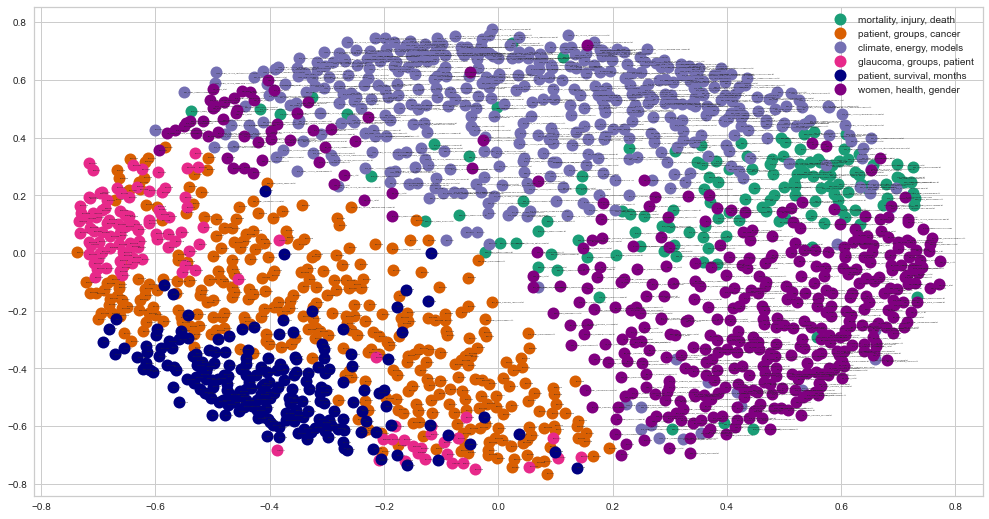

In [13]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, document=document)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

# #add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['document'], size=2)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

# Clustering with 2 features (sentences,EU Call)

In [ ]:
# Opening JSON file
f = open('dataset_aueb_argument_v3.json',)

# returns JSON object as 
# a dictionary
data = json.load(f)

# Closing file
f.close()

df = pd.DataFrame(data)
df = df.T
df.reset_index(drop=True, inplace=True)
del df['team']
df.head(5)

,SDG,eu_call,project_objective,url,sentences,labels
0,3,H2020-EU.1.1.,Critical to our understanding of Alzheimer’s d...,Cordis URL: https://cordis.europa.eu/project/i...,[Concordance Between Different Amyloid Immunoa...,"[neither, neither, neither, neither, neither, ..."
1,3,H2020-EU.1.1.,Critical to our understanding of Alzheimer’s d...,Cordis URL: https://cordis.europa.eu/project/i...,[Association of Changes in Plasma Neurofilamen...,"[neither, neither, neither, neither, neither, ..."
2,13,H2020-EU.1.3.2.,Fluid overpressure has been proposed as one of...,Cordis URL: https://cordis.europa.eu/project/i...,[Dynamically triggered slip leading to sustain...,"[neither, neither, neither, evidence, evidence..."
3,13,H2020-EU.1.3.2.,Circulation changes are at the heart of change...,Cordis URL: https://cordis.europa.eu/project/i...,[Impacts of parameterized orographic drag on t...,"[neither, neither, neither, neither, neither, ..."
4,13,H2020-EU.1.3.2.,Circulation changes are at the heart of change...,Cordis URL: https://cordis.europa.eu/project/i...,"[Climate model biases in jet streams, blocking...","[neither, neither, neither, neither, neither, ..."


In [ ]:
df = df.explode('sentences').reset_index()
df['sentences'] = df.groupby('index')['sentences'].transform(lambda x: ','.join(x))
df = df.drop_duplicates('sentences')[['index','eu_call',"sentences"]]

In [ ]:
# Opening JSON file
call = open('eu_calls.json',)

# returns JSON object as 
# a dictionary
calleu = json.load(call)

# Closing file
call.close()

In [ ]:
calleu
callw = pd.DataFrame(calleu, index=[0])
callw = callw.T.reset_index()
callw.rename(columns={ callw.columns[1]: "eu_calls" }, inplace = True)
callw

,index,eu_calls
0,H2020-EU.3.1.1.,"SOCIETAL CHALLENGES - Health, demographic chan..."
1,H2020-EU.1.1.,EXCELLENT SCIENCE - European Research Council ...
2,H2020-EU.3.1.6.,"SOCIETAL CHALLENGES - Health, demographic chan..."
3,H2020-EU.3.1.3.,"SOCIETAL CHALLENGES - Health, demographic chan..."
4,H2020-EU.1.3.1.,Fostering new skills by means of excellent ini...
5,H2020-EU.3.5.1.,Fighting and adapting to climate change\n\nThe...
6,H2020-EU.1.4.1.3.,Developing the European research infrastructur...
7,H2020-EU.2.1.6.3.,Enabling exploitation of space data\n \nA cons...
8,H2020-EU.1.3.2.,Nurturing excellence by means of cross-border ...
9,H2020-EU.1.2.1.,FET Open\n \n\tBy fostering novel ideas ('FET ...


In [ ]:
new_df = df.merge(callw,left_on = 'eu_call', right_on = 'index',how='inner')
new_df = new_df[['eu_calls','sentences']]
new_df

,eu_calls,sentences
0,EXCELLENT SCIENCE - European Research Council ...,Concordance Between Different Amyloid Immunoas...
1,EXCELLENT SCIENCE - European Research Council ...,Association of Changes in Plasma Neurofilament...
2,EXCELLENT SCIENCE - European Research Council ...,Is Anti-Citrullinated Protein Antibody-Positiv...
3,EXCELLENT SCIENCE - European Research Council ...,Design and Performance of Rechargeable Sodium ...
4,EXCELLENT SCIENCE - European Research Council ...,Human versus Robots in the Discovery and Cryst...
...,...,...
1010,Enabling exploitation of space data\n \nA cons...,Carbon dioxide emissions continue to grow amid...
1011,Enabling exploitation of space data\n \nA cons...,Satellite and In Situ Observations for Advanci...
1012,Enabling exploitation of space data\n \nA cons...,Upgraded global mapping information for earth ...
1013,"SOCIETAL CHALLENGES - Health, demographic chan...",Methods for predicting vaccine immunogenicity ...


In [ ]:

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,
                                 min_df=0.05, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix_2 = tfidf_vectorizer.fit_transform(new_df['sentences']) #fit the vectorizer to synopses
terms_sentences = tfidf_vectorizer.get_feature_names()

%time tfidf_matrix_3 =  tfidf_vectorizer.fit_transform(new_df['eu_calls']) #fit the vectorizer to synopses
terms_eu_call = tfidf_vectorizer.get_feature_names()


tfidf_matrix_2_final = sparse.hstack((sparse.csr_matrix(tfidf_matrix_2),sparse.csr_matrix(tfidf_matrix_3)))
print(tfidf_matrix_2_final.shape)
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix_2_final)
print
print
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 5.56 s, sys: 41.8 ms, total: 5.6 s
Wall time: 5.62 s
CPU times: user 8.2 s, sys: 25 ms, total: 8.22 s
Wall time: 8.22 s
(1015, 2132)


<function print>

- The two terms list are merged together. 

In [ ]:
terms = terms_sentences + terms_eu_call

- Converting tfidf_matrix to csr since 'coo_matrix' object is not subscriptable

In [ ]:
tfidf_matrix_2_final.tocsr()

<1015x2132 sparse matrix of type '<class 'numpy.float64'>'
	with 523894 stored elements in Compressed Sparse Row format>

In [ ]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in new_df['sentences']:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'sentences', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in new_df['eu_calls']:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'sentences', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)    
vocab_frame_2 = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame = pd.concat([vocab_frame,vocab_frame_2])
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 383440 items in vocab_frame


In [ ]:
from sklearn.cluster import KMeans

num_clusters = 6

%time km2 = KMeans(n_clusters=num_clusters).fit(tfidf_matrix_2_final)
labels = km2.labels_
clusters = km2.labels_.tolist()
new_df['clusters'] = clusters
#print(clusters)
silhouette_score = metrics.silhouette_score(tfidf_matrix_2_final, labels, metric='euclidean')
print(silhouette_score)

CPU times: user 55.9 s, sys: 11.1 s, total: 1min 7s
Wall time: 55 s
0.2953310498008276


In [ ]:
print("Top terms per cluster:")
order_centroids_2 = km2.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids_2[i, :4]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print() #add whitespace
    print() #add whitespace
    
#     print("Cluster %d documents:" % i, end='')
#     print(' %s,' % text_cluster[text_cluster['clusters'] == i]['document'].values.tolist(), end='')
#     print() #add whitespace
#     print() #add whitespace
    
print()
print()

Top terms per cluster:
Cluster 0: sciences, europe, unit, many,

Cluster 1: training, post-graduate, career, knowledge,

Cluster 2: disease, health, millions, well-being,

Cluster 3: climate, climate, models, mitigation,

Cluster 4: operating, research, infrastructure, models,

Cluster 5: open, opportunity, shall, shall,





In [ ]:
#document = text_cluster.document.tolist()

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#000080', 5: '#800080', 6:'#808000'}

#set up cluster names using a dict
cluster_names = {0: 'disability, growth, methods, welfare', 
                 1: 'safety, estimate, union, managed', 
                 2: 'classic, climate, models, millions', 
                 3: 'once, operating, several, shall', 
                 4: 'total, population, care, jobs',
                 5: 'once, research, information, models'}

MDS()
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

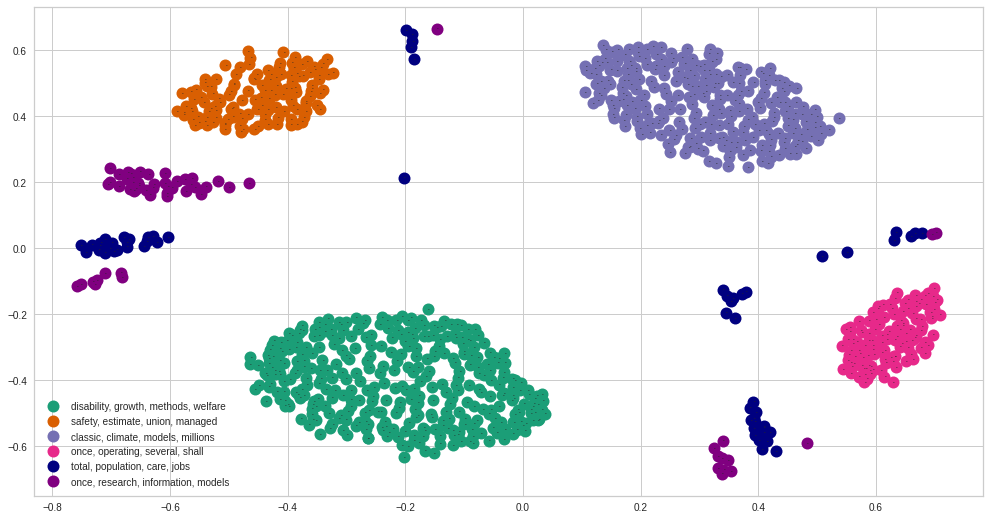

<Figure size 432x288 with 0 Axes>

In [ ]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

# #add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'],df.iloc[i]['label'],size=2)

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)

=============================================================================

# Abstract DE and eu_call and the argument (claim/evidence) embeddings

In [93]:
# Opening JSON file
f = open('dataset_aueb_argument_v3.json',)

# returns JSON object as 
# a dictionary
data = json.load(f)

# Closing file
f.close()

df = pd.DataFrame(data)
df = df.T
df.reset_index(drop=True, inplace=True)
del df['team']
df.head(5)

,SDG,eu_call,project_objective,url,sentences,labels
0,3,H2020-EU.1.1.,Critical to our understanding of Alzheimer’s d...,Cordis URL: https://cordis.europa.eu/project/i...,[Concordance Between Different Amyloid Immunoa...,"[neither, neither, neither, neither, neither, ..."
1,3,H2020-EU.1.1.,Critical to our understanding of Alzheimer’s d...,Cordis URL: https://cordis.europa.eu/project/i...,[Association of Changes in Plasma Neurofilamen...,"[neither, neither, neither, neither, neither, ..."
2,13,H2020-EU.1.3.2.,Fluid overpressure has been proposed as one of...,Cordis URL: https://cordis.europa.eu/project/i...,[Dynamically triggered slip leading to sustain...,"[neither, neither, neither, evidence, evidence..."
3,13,H2020-EU.1.3.2.,Circulation changes are at the heart of change...,Cordis URL: https://cordis.europa.eu/project/i...,[Impacts of parameterized orographic drag on t...,"[neither, neither, neither, neither, neither, ..."
4,13,H2020-EU.1.3.2.,Circulation changes are at the heart of change...,Cordis URL: https://cordis.europa.eu/project/i...,"[Climate model biases in jet streams, blocking...","[neither, neither, neither, neither, neither, ..."


In [94]:
sentences = df['sentences'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'sentences': 'sentence'})
sentences
labels = df['labels'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'labels': 'label'})
labels

,doc_id,label
0,0,neither
1,0,neither
2,0,neither
3,0,neither
4,0,neither
...,...,...
10570,1016,neither
10571,1016,neither
10572,1016,neither
10573,1016,neither


In [95]:
sentences['label'] = labels['label']
sentences

,doc_id,sentence,label
0,0,Concordance Between Different Amyloid Immunoas...,neither
1,0,Importance Visual assessment of amyloid positr...,neither
2,0,Several immunoassays have been developed to me...,neither
3,0,The agreement between CSF Aβ42 measures from d...,neither
4,0,Objective To determine the concordance between...,neither
...,...,...,...
10570,1016,"Instead, SBPs sample a range of conformations ...",neither
10571,1016,Certain non-transported ligands leave the stru...,neither
10572,1016,"Intriguingly, in some cases, similar SBP confo...",neither
10573,1016,"In this case, the inability for transport aris...",neither


In [96]:
sentences = sentences[sentences['label'] != 'neither']

In [97]:
df = df.explode('sentences').reset_index()
df['sentences'] = df.groupby('index')['sentences'].transform(lambda x: ','.join(x))
df = df.drop_duplicates('sentences')[['index','eu_call',"sentences",'labels']]

In [98]:
# Opening JSON file
call = open('eu_calls.json',)

# returns JSON object as 
# a dictionary
calleu = json.load(call)

# Closing file
call.close()

callw = pd.DataFrame(calleu, index=[0])
callw = callw.T.reset_index()
callw.rename(columns={ callw.columns[1]: "eu_calls" }, inplace = True)
callw

,index,eu_calls
0,H2020-EU.3.1.1.,"SOCIETAL CHALLENGES - Health, demographic chan..."
1,H2020-EU.1.1.,EXCELLENT SCIENCE - European Research Council ...
2,H2020-EU.3.1.6.,"SOCIETAL CHALLENGES - Health, demographic chan..."
3,H2020-EU.3.1.3.,"SOCIETAL CHALLENGES - Health, demographic chan..."
4,H2020-EU.1.3.1.,Fostering new skills by means of excellent ini...
5,H2020-EU.3.5.1.,Fighting and adapting to climate change\n\nThe...
6,H2020-EU.1.4.1.3.,Developing the European research infrastructur...
7,H2020-EU.2.1.6.3.,Enabling exploitation of space data\n \nA cons...
8,H2020-EU.1.3.2.,Nurturing excellence by means of cross-border ...
9,H2020-EU.1.2.1.,FET Open\n \n\tBy fostering novel ideas ('FET ...


In [99]:
new_df = df.merge(callw,left_on = 'eu_call', right_on = 'index',how='inner')
new_df = new_df[['eu_calls','sentences','labels']]
new_df

,eu_calls,sentences,labels
0,EXCELLENT SCIENCE - European Research Council ...,Concordance Between Different Amyloid Immunoas...,"[neither, neither, neither, neither, neither, ..."
1,EXCELLENT SCIENCE - European Research Council ...,Association of Changes in Plasma Neurofilament...,"[neither, neither, neither, neither, neither, ..."
2,EXCELLENT SCIENCE - European Research Council ...,Is Anti-Citrullinated Protein Antibody-Positiv...,"[neither, neither, neither, neither, neither, ..."
3,EXCELLENT SCIENCE - European Research Council ...,Design and Performance of Rechargeable Sodium ...,"[neither, neither, neither, neither, neither, ..."
4,EXCELLENT SCIENCE - European Research Council ...,Human versus Robots in the Discovery and Cryst...,"[neither, neither, neither, claim, neither, ev..."
...,...,...,...
1010,Enabling exploitation of space data\n \nA cons...,Carbon dioxide emissions continue to grow amid...,"[neither, neither, claim]"
1011,Enabling exploitation of space data\n \nA cons...,Satellite and In Situ Observations for Advanci...,"[neither, neither, neither, neither, neither, ..."
1012,Enabling exploitation of space data\n \nA cons...,Upgraded global mapping information for earth ...,"[neither, neither, neither, neither, neither, ..."
1013,"SOCIETAL CHALLENGES - Health, demographic chan...",Methods for predicting vaccine immunogenicity ...,"[neither, neither, neither, neither, neither, ..."


In [100]:
new_df = new_df.explode('labels').reset_index()
new_df = new_df.groupby(['index','eu_calls','sentences']).agg(labels = ('labels',','.join)).reset_index()

In [101]:
new_df

,index,eu_calls,sentences,labels
0,0,EXCELLENT SCIENCE - European Research Council ...,Concordance Between Different Amyloid Immunoas...,"neither,neither,neither,neither,neither,neithe..."
1,1,EXCELLENT SCIENCE - European Research Council ...,Association of Changes in Plasma Neurofilament...,"neither,neither,neither,neither,neither,neithe..."
2,2,EXCELLENT SCIENCE - European Research Council ...,Is Anti-Citrullinated Protein Antibody-Positiv...,"neither,neither,neither,neither,neither,neithe..."
3,3,EXCELLENT SCIENCE - European Research Council ...,Design and Performance of Rechargeable Sodium ...,"neither,neither,neither,neither,neither,eviden..."
4,4,EXCELLENT SCIENCE - European Research Council ...,Human versus Robots in the Discovery and Cryst...,"neither,neither,neither,claim,neither,evidence..."
...,...,...,...,...
1010,1010,Enabling exploitation of space data\n \nA cons...,Carbon dioxide emissions continue to grow amid...,"neither,neither,claim"
1011,1011,Enabling exploitation of space data\n \nA cons...,Satellite and In Situ Observations for Advanci...,"neither,neither,neither,neither,neither,eviden..."
1012,1012,Enabling exploitation of space data\n \nA cons...,Upgraded global mapping information for earth ...,"neither,neither,neither,neither,neither,neithe..."
1013,1013,"SOCIETAL CHALLENGES - Health, demographic chan...",Methods for predicting vaccine immunogenicity ...,"neither,neither,neither,neither,neither,neither"


In [102]:
sentences

,doc_id,sentence,label
8,0,Main Outcomes and Measures The concordance of ...,evidence
9,0,"Results Of 262 participants (mean [SD] age, 70...",evidence
10,0,The mass spectrometry–derived Aβ42 values show...,evidence
11,0,The signal in the classic Aβ42-INNOTEST assay ...,evidence
12,0,"However, the classic Aβ42-INNOTEST assay showe...",evidence
...,...,...,...
10554,1014,Our study generalizes a previous one by Fukush...,evidence
10556,1014,Our preliminary results on coarse lattices sho...,claim
10563,1015,We propose that GLP-1/Notch promotes reprogram...,evidence
10564,1015,"These findings have wide implications, ranging...",claim


In [103]:
sentences = sentences.groupby(['doc_id']).agg(labels = ('sentence',','.join)).reset_index()
sentences

,doc_id,labels
0,0,Main Outcomes and Measures The concordance of ...
1,1,Main Outcomes and Measures Plasma neurofilamen...
2,2,When the system is sheared under steady state ...
3,3,"This increase was simulated in two ways, namel..."
4,4,Here we show that the effects of switching off...
...,...,...
780,1008,Our results demonstrate that the generalized P...
781,1011,These show that higher values of P* generally ...
782,1014,Our study generalizes a previous one by Fukush...
783,1015,We propose that GLP-1/Notch promotes reprogram...


In [108]:
new_df = new_df[['index','eu_calls','sentences']]
new_df = new_df.merge(sentences,left_on = "index",right_on = 'doc_id',how = 'inner').drop(columns = 'doc_id')

In [110]:
new_df

,index,eu_calls,sentences,labels
0,0,EXCELLENT SCIENCE - European Research Council ...,Concordance Between Different Amyloid Immunoas...,Main Outcomes and Measures The concordance of ...
1,1,EXCELLENT SCIENCE - European Research Council ...,Association of Changes in Plasma Neurofilament...,Main Outcomes and Measures Plasma neurofilamen...
2,2,EXCELLENT SCIENCE - European Research Council ...,Is Anti-Citrullinated Protein Antibody-Positiv...,When the system is sheared under steady state ...
3,3,EXCELLENT SCIENCE - European Research Council ...,Design and Performance of Rechargeable Sodium ...,"This increase was simulated in two ways, namel..."
4,4,EXCELLENT SCIENCE - European Research Council ...,Human versus Robots in the Discovery and Cryst...,Here we show that the effects of switching off...
...,...,...,...,...
778,1006,"SOCIETAL CHALLENGES - Health, demographic chan...","Ebola vaccine R&D: Filling the knowledge gaps,...","Importantly, the observed streamflow database ..."
779,1007,"SOCIETAL CHALLENGES - Health, demographic chan...",A dose-dependent plasma signature of the safet...,The results also suggested that different patt...
780,1008,"SOCIETAL CHALLENGES - Health, demographic chan...","Biomarkers of Cutaneous Leishmaniasis,Internat...",Our results demonstrate that the generalized P...
781,1011,Enabling exploitation of space data\n \nA cons...,Satellite and In Situ Observations for Advanci...,These show that higher values of P* generally ...


In [112]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,
                                 min_df=0.05, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix_2 = tfidf_vectorizer.fit_transform(new_df['sentences']) #fit the vectorizer to synopses
terms_sentences = tfidf_vectorizer.get_feature_names()

%time tfidf_matrix_3 =  tfidf_vectorizer.fit_transform(new_df['eu_calls']) #fit the vectorizer to synopses
terms_eu_call = tfidf_vectorizer.get_feature_names()

%time tfidf_matrix_4 =  tfidf_vectorizer.fit_transform(new_df['labels']) #fit the vectorizer to synopses
terms_labels = tfidf_vectorizer.get_feature_names()


tfidf_matrix_3_final = sparse.hstack((sparse.csr_matrix(tfidf_matrix_2),sparse.csr_matrix(tfidf_matrix_3)))
tfidf_matrix_3_final = sparse.hstack((sparse.csr_matrix(tfidf_matrix_3_final),sparse.csr_matrix(tfidf_matrix_4)))
print(tfidf_matrix_3_final.shape)
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix_3_final)
print
print
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 4.7 s, sys: 88.7 ms, total: 4.78 s
Wall time: 4.81 s
CPU times: user 6.31 s, sys: 7.36 ms, total: 6.31 s
Wall time: 6.33 s
CPU times: user 1.75 s, sys: 8.35 ms, total: 1.76 s
Wall time: 1.76 s
(783, 2231)


<function print>

In [113]:
terms = terms_sentences + terms_eu_call + terms_labels

In [114]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in new_df['sentences']:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'sentences', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in new_df['eu_calls']:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'sentences', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
vocab_frame_2 = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
for i in new_df['labels']:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'sentences', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)  
vocab_frame_3 = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame = pd.concat([vocab_frame,vocab_frame_2,vocab_frame_3])
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 518784 items in vocab_frame


In [116]:
from sklearn.cluster import KMeans

num_clusters = 6

%time km3 = KMeans(n_clusters=num_clusters).fit(tfidf_matrix_3_final)
labels = km3.labels_
clusters = km3.labels_.tolist()
new_df['clusters'] = clusters
#print(clusters)
silhouette_score = metrics.silhouette_score(tfidf_matrix_3_final, labels, metric='euclidean')
print(silhouette_score)

CPU times: user 32.5 s, sys: 7.79 s, total: 40.3 s
Wall time: 31.7 s
0.18499743057801976


In [125]:
terms = list(dict.fromkeys(terms))

In [128]:
order_centroids_3 = km3.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids_3[i, :3]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print() #add whitespace
    print() #add whitespace

Cluster 0: competitive, climate, models,

Cluster 1: doctoral, impacts, offering,

Cluster 2: specific, network, become,

Cluster 3: world-class, ranked, death,

Cluster 4: private, processes, sustained,

Cluster 5: private, sector, knowledge,



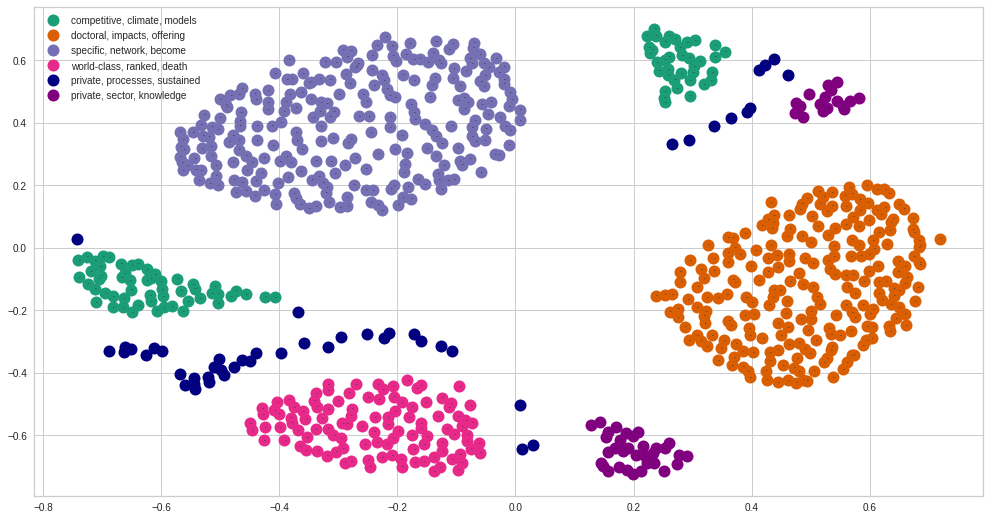

<Figure size 432x288 with 0 Axes>

In [129]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#000080', 5: '#800080', 6:'#808000'}

#set up cluster names using a dict
cluster_names = {0: 'competitive, climate, models', 
                 1: 'doctoral, impacts, offering', 
                 2: 'specific, network, become', 
                 3: 'world-class, ranked, death', 
                 4: 'private, processes, sustained',
                 5: 'private, sector, knowledge'}

MDS()
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

# #add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'],df.iloc[i]['label'], size=2)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)